# Personal Information
Name: **Lucas Belderink**

StudentID: **12151750**

Email: [**lucas.belderink@student.uva.nl**](lucas.belderink@student.uva.nl)

Submitted on: **22.3.2024**

github link: [**https://github.com/Looqes/pca_thesis_project**](https://github.com/Looqes/pca_thesis_project)

# Data Context

The data used in this project consists of sets of images for 170 different patients, acquired from different scanners at different times. The data belongs to the NKI and is aquired from past patients. The images come in the form of .nii files, a common format for multidimensional medical imaging data and are 3-dimensional, thus layered. Also added to the data are .nrrd delineation files which carry the tumor delineations. These are made by pathology within the NKI following radical prostatectomies (in which the prostate is removed). Finally, a folder is included containing tumor delineations made by expert radiologists based on their interpretation of MRI's. These will be used at a later time however as the main focus lies on just using the mri's to train a model to make delineations. For now these will not be loaded and/or used.

# Data Description

For each patient the relevant data (at least at this moment) consists of the following:
+ axial-plane T2 scan
+ A Diffusion Weighted Imaging (DWI) Apparent Diffusion Coefficient (ADC) map
+ A DWI Perfusion map

The axial plane T2 scan is relevant because the other images are also in the axial plane, and the objective is to match and overlap them to then feed them to the model. A python package called nibabel is used to open them & gather their image data as numerical arrays, and other metadata. The first goal is to see how the resolutions of the images vary across patients, as it is apparent beforehand by manual inspection that they vary slightly between patients. To use the data with the model the image have to be resized to a common resultion per patient. The resolution between patients does not have to be the same necessarily as the model planned to be used (nnUnet) does some preprocessing automatically and will take care of this. \

For the delineations, for every patient, a number of .nrrd files is included containing the delineations mapped to the T2 axial scans. When these are opened in conjunction using visualization software in the form of Slicer they overlap and create information about the position and presence of a tumor. They are mapped specifically to the T2 scans for the patients and thus share their resolution. Not all slices of a patient that does actually have a tumor contain delineations however, as the tumor usually does not span the entire prostate. Thus the set of slices that have mapped tumor delineations, in case of the presence of a tumor, is always a subset of the total amount of slices in a patient.

In [1]:
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# EDA

In [2]:
import sys
import importlib
from os import listdir

from collections import defaultdict
import numpy as np
import pandas as pd
import pylab as plt
# import matplotlib as plt
%matplotlib inline
import SimpleITK as sitk

# Custom objects included in scripts
from scripts.patient import Patient
from scripts import read_scans_utils

In [3]:

importlib.reload(sys.modules["scripts.patient"])
importlib.reload(sys.modules["scripts.read_scans_utils"])
from scripts.patient import Patient
from scripts import read_scans_utils

In [4]:
# The amount of patients available
img_folders = [f for f in listdir("Scans")]
print(len(img_folders))


170


### Taking a look at imaging data for a patient

In [5]:
# Read sample patient
patient7 = read_scans_utils.read_patient("MARPROC007_nii")


(512, 512, 30)


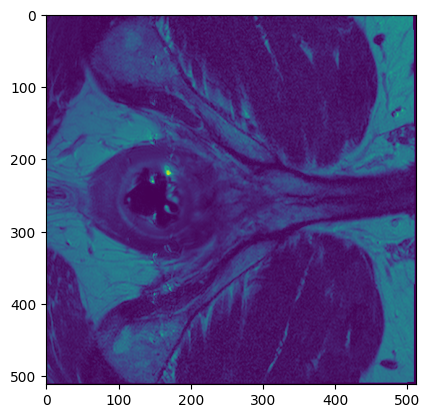

In [6]:
# Extract & plot an axial T2 image
axialt2_p7 = patient7.axialt2

# Print the shape of the image
# x, y, z, where x, y is the resolution of a single slice of the 3d image, and z the amount of slices
print(np.asanyarray(axialt2_p7.dataobj).shape)
# print the first slice in the image
plt.imshow(np.asanyarray(axialt2_p7.dataobj)[:, :, 0])

(176, 176, 20)


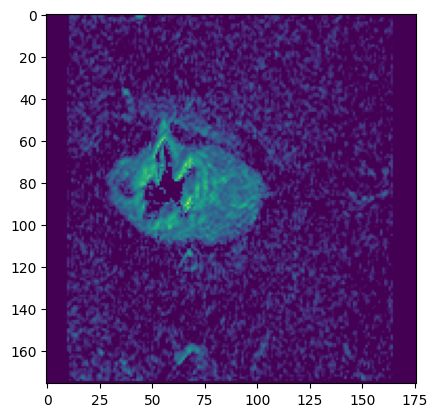

In [7]:
adcmap_p7 = patient7.adcmap

# ADC maps have a different resolution, and a different amount of slices per patient
# For use in the training of a model, they will need to be resized to a common size
print(np.asanyarray(adcmap_p7.dataobj).shape)

# Plot adcmap image
plt.imshow(np.asanyarray(adcmap_p7.dataobj[:, :, 0]))

(176, 176, 20)


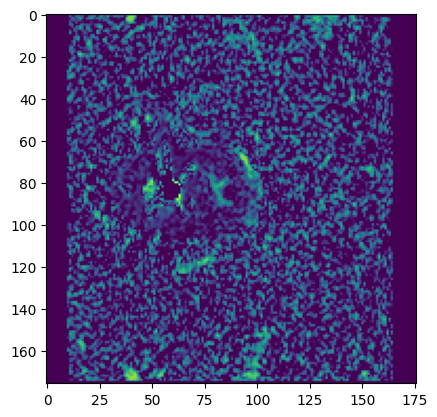

In [8]:
perffrac_p7 = patient7.perfusionmap

# Perfusion maps have the same resolution as ADC maps
print(np.asanyarray(perffrac_p7.dataobj).shape)

# Plot a perfusionmap image
plt.imshow(np.asanyarray(perffrac_p7.dataobj[:, :, 0]))

In [9]:
# Each of the images are .nii or NifTi files, meaning they carry alot more metadata next to the actual imaging data
print(patient7.axialt2)
# print(patient7.adcmap)
# print(patient7.perfusionmap)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (512, 512, 30)
affine:
[[-2.72656471e-01 -1.48925167e-02  1.56984076e-01  7.84771729e+01]
 [-1.49605758e-02  2.73026407e-01 -1.00043723e-02 -4.59993896e+01]
 [ 1.42372679e-02  1.69210962e-03  2.99587297e+00 -2.53421497e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 512 512  30   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.         0.2734375  0.2734375  2.9999998  1.         1.
  1.         1.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal

### Checking consistency across the whole set

First, the entire set will have to be read

In [10]:
patients = defaultdict()

erroneous_data_patients = []

for folder in img_folders:
    patient_id = folder.replace("_nii", "")
    patient = read_scans_utils.read_patient(folder)
    
    if patient != None:
        patients[patient_id] = patient
    else:
        erroneous_data_patients.append(patient_id)

print("Amount of patient successfully read:")
print(len(patients))

 

Couldnt find axialt2
MARPROC090_nii
['201_t2_tse_cor.nii', '301_t2_tse.nii']
###############

Couldnt find axialt2
MARPROC144_nii
['301_s_t2_tse.nii', '501_c_t2_tse.nii']
###############

Couldnt find axialt2
MARPROC373_nii
['301_s_t2_tse.nii', '501_c_t2_tse.nii']
###############

Couldnt find axialt2
MARPROC415_nii
['401_t2_tse.nii', '601_ct2_tse.nii']
###############

Couldnt find axialt2
MARPROC422_nii
['201_t2_tse_cor.nii', '301_t2_tse.nii']
###############

Amount of patient successfully read:
165


Now to investigate how the resolutions of imaging differ between different patients the distribution of resolutions will be examined

In [11]:
t2_resolutions = defaultdict(int)
adc_resolutions = defaultdict(int)
perf_resolutions = defaultdict(int)

for patient_id in patients:
    patient = patients[patient_id]

    t2_resolutions[np.asarray(patient.axialt2.dataobj).shape] += 1

    adc_resolutions[np.asarray(patient.adcmap.dataobj).shape] += 1

    perf_resolutions[np.asarray(patient.perfusionmap.dataobj).shape] += 1

    

df1 = pd.DataFrame(t2_resolutions.items(), columns = ["Resolution", "Occurrences"]).sort_values("Occurrences", ascending = False)
df2 = pd.DataFrame(adc_resolutions.items(), columns = ["Resolution", "Occurrences"]).sort_values("Occurrences", ascending = False)
df3 = pd.DataFrame(perf_resolutions.items(), columns = ["Resolution", "Occurrences"]).sort_values("Occurrences", ascending = False)

read_scans_utils.display_side_by_side(df1, df2, df3)

# display(df)

,Resolution,Occurrences
0,"(512, 512, 30)",57
2,"(720, 720, 30)",50
8,"(704, 704, 25)",24
5,"(704, 704, 30)",17
3,"(720, 720, 32)",4
10,"(720, 720, 35)",3
7,"(704, 704, 28)",2
1,"(720, 720, 40)",1
4,"(512, 512, 29)",1
6,"(576, 576, 30)",1


Most of the scans have a consistent resolution, with slight variation in a part of the data.
There are however some variations in either the resolution, the amount of slices, or both.\
Also important to note, is that the perfusion scans and adc scans overlap in their resolutions and slice amounts exactly, meaning the only thing that remains for scaling them for use in the network is to match them to their accompanying T2w scans together.

### Opening the delineation files

In [12]:
importlib.reload(sys.modules["scripts.patient"])
importlib.reload(sys.modules["scripts.read_scans_utils"])
from scripts.patient import Patient
from scripts import read_scans_utils

In [13]:
# Reads delineations in the format: {patient_id: [(name_of_file, [array, metadata])
#                                                 (name_of_file, ......           )
#                                                ]
#                                   }
delineations = read_scans_utils.read_delineations()

print(len(delineations))
print(len(delineations["MARPROC007"]))
print([x[0] for x in delineations["MARPROC007"]])
print(delineations["MARPROC007"][0][1][1])

100%|██████████| 170/170 [00:32<00:00,  5.20it/s]

170
2
['p_GG-p_GG3-label.nrrd', 'p_GG-p_GG4-label.nrrd']
OrderedDict([('type', 'short'), ('dimension', 3), ('space', 'left-posterior-superior'), ('sizes', array([512, 512,  30])), ('space directions', array([[ 2.72656465e-01,  1.49605753e-02,  1.42372683e-02],
       [-1.48925170e-02,  2.73026402e-01, -1.69210962e-03],
       [-1.56984061e-01,  1.00043723e-02,  2.99587302e+00]])), ('kinds', ['domain', 'domain', 'domain']), ('endian', 'little'), ('encoding', 'gzip'), ('space origin', array([-70.86709377, -93.51709731, -24.4774819 ]))])


In [14]:
foldername_delins = "./Regions ground truth/Regions delineations/"

delin_folders = [f for f in listdir(foldername_delins)]
print("Amount of patient folders included in the dataset: ", len(delin_folders))

delineations_counts = defaultdict(int)
patients_to_skip = {x for x in erroneous_data_patients}
print(patients_to_skip)

# Count the amount of delineation files per patient to see what is the distribution of file counts
for patient_id, patient_delineations in delineations.items():
    if patient_id in patients_to_skip:
        continue
    
    delineations_counts[(len(patient_delineations))] += 1


del_counts_df = pd.DataFrame(delineations_counts.items(), columns = ["Amount of delineations", "count"]).sort_values("count", ascending=False)
display(del_counts_df)
print(del_counts_df["count"].sum())

Amount of patient folders included in the dataset:  170
{'MARPROC373', 'MARPROC415', 'MARPROC422', 'MARPROC144', 'MARPROC090'}


,Amount of delineations,count
0,2,63
1,3,57
2,1,32
4,4,9
3,5,3
5,6,1


165


Most patients have 2 delineation files. There are a few outliers with 5 and even 6 files.

In [15]:
patient = None
delineation = None

print("Delineations for single patients: ")
i = 0
for patient_id, delineations_patient in delineations.items():
    print(patient_id, [delineations_patient[i][0] for i in range(len(delineations_patient))])
    i += 1
    if i > 4:
        break


nrrd_delineations = delineations["MARPROC007"]
nrrd_delineations2 = delineations["MARPROC343"]
print("\nDelineation data for a single patient:")
print(nrrd_delineations[0][0])
print(nrrd_delineations[0][1][0].shape)
print(nrrd_delineations[0][1][1])
print()
print(nrrd_delineations2[0][0])
print(nrrd_delineations2[0][1][0].shape)
print(nrrd_delineations2[0][1][1])


patient_6files = delineations["MARPROC204"]
print("\nThe files in the folder of the patient with the most files (6):")
print([patient_6files[i][0] for i in range(len(patient_6files))])

# Printing 2 files for patient 204 of different zones for GG3 regions
# They should match in resolution
print("\nResolution of GG3 in TZ and GG3 in PZ of patient 204:")
patient_204_delins = delineations["MARPROC204"]
for delin in patient_204_delins:
    if "GG3" in delin[0]:
        print(delin[0])
        print(delin[1][0].shape, "\n")


Delineations for single patients: 
MARPROC007 ['p_GG-p_GG3-label.nrrd', 'p_GG-p_GG4-label.nrrd']
MARPROC009 ['p_GG-p_Cribriform-label.nrrd', 'p_GG-p_GG3-label.nrrd', 'p_GG-p_GG4-label.nrrd']
MARPROC012 ['p_GG-p_GG3-label.nrrd']
MARPROC015 ['p_GG-p_GG3-label.nrrd', 'p_GG-p_GG4-label.nrrd']
MARPROC017 ['p_GG-p_Atrophy-label.nrrd', 'p_GG-p_GG3-label.nrrd', 'p_GG-p_GG4-label.nrrd']

Delineation data for a single patient:
p_GG-p_GG3-label.nrrd
(512, 512, 30)
OrderedDict([('type', 'short'), ('dimension', 3), ('space', 'left-posterior-superior'), ('sizes', array([512, 512,  30])), ('space directions', array([[ 2.72656465e-01,  1.49605753e-02,  1.42372683e-02],
       [-1.48925170e-02,  2.73026402e-01, -1.69210962e-03],
       [-1.56984061e-01,  1.00043723e-02,  2.99587302e+00]])), ('kinds', ['domain', 'domain', 'domain']), ('endian', 'little'), ('encoding', 'gzip'), ('space origin', array([-70.86709377, -93.51709731, -24.4774819 ]))])

p_GG-p_Cribriform-label.nrrd
(26, 512, 512)
OrderedDict([

Patients have a combination of files representing regions of differing GG tissue. Also, as visible from the patient with the most delineation files available across all patients multiple files are available for even a single GG. This means that the tumor that is delineated for this patient, and its GG regions, cover the two different zones of the prostate: the peripheral zone (PZ) and the transition zone (TZ). For this research the seperation between zones is not relevant, so these will be combined. As visible above in this case they share resolution, since they are both still registered to the entire T2 scan. A total GG3 region delineation will be formed by performing an OR operation of the files for both zones.
As visible the delineation, when opened using pynrrd consists of a 3d image in the form of a 3d numerical array, matching the resolution of the T2 axial image loaded earlier. Also some metadata is included. 

To check the distribution of resolutions of the files:

In [16]:
delin_resolutions = defaultdict(int)

for patient_id, delineations_patient in delineations.items():
    shapes = set()

    for delineation in delineations_patient:
        shapes.add(delineation[1][0].shape)
    if len(shapes) == 1:
        delin_resolutions[shapes.pop()] += 1


delin_resolutions_df = pd.DataFrame(delin_resolutions.items(), columns=["resolution", "count"])
display(delin_resolutions_df)

,resolution,count
0,"(512, 512, 30)",55
1,"(720, 720, 40)",1
2,"(720, 720, 30)",49
3,"(720, 720, 32)",4
4,"(512, 512, 29)",2
5,"(704, 704, 30)",15
6,"(576, 576, 30)",2
7,"(704, 704, 28)",2
8,"(704, 704, 25)",22
9,"(704, 704, 23)",3


The delineations seem to contain some differing resolutions as there are more unique resolutions (20) than the amount of resolutions in the T2 axial scans (14). Some additional checks will have to be done when adding the delineations to the patients to ensure they match T2 resolution. As of now it is not yet completely clear how to represent the delineations within a patient or slice so the reading will be performed later (this is also not necessary for the EDA).

In [17]:
patient_1_delineations = delineations["MARPROC007"]

# iterate over slices
delineated_slices = []
print(patient_1_delineations[0][0])
for i, slice in enumerate(np.rollaxis(patient_1_delineations[0][1][0], 2)):
    if 1 in slice:
        delineated_slices.append(i)

print("\nSlices that contain a delineation: ")
print(delineated_slices)



p_GG-p_GG3-label.nrrd

Slices that contain a delineation: 
[11, 12, 13, 14, 15, 16, 17]


### Checking in how many cases the shape of the delineation of a patient matches the loaded axial t2 of that patient

In [18]:
bad_delin_patients = set()

for patient_id, delineations_patient in delineations.items():
    delineations_shape_patient = delineations_patient[0][1][0].shape

    if patient_id in patients:
        t2_shape_patient = patients[patient_id].get_axialt2_image_array().shape

        if delineations_shape_patient != t2_shape_patient:
            bad_delin_patients.add(patient_id)
            print(patient_id, ": Shape of delineations and t2 doesnt match")
            print("dimensions of delineations: ", delineations_shape_patient)
            print("Axialt2 of patient:         ", t2_shape_patient)
            print()


MARPROC031 : Shape of delineations and t2 doesnt match
dimensions of delineations:  (512, 512, 29)
Axialt2 of patient:          (512, 512, 30)

MARPROC062 : Shape of delineations and t2 doesnt match
dimensions of delineations:  (704, 704, 23)
Axialt2 of patient:          (704, 704, 25)

MARPROC069 : Shape of delineations and t2 doesnt match
dimensions of delineations:  (704, 704, 23)
Axialt2 of patient:          (704, 704, 25)

MARPROC099 : Shape of delineations and t2 doesnt match
dimensions of delineations:  (704, 704, 27)
Axialt2 of patient:          (704, 704, 30)

MARPROC101 : Shape of delineations and t2 doesnt match
dimensions of delineations:  (704, 704, 23)
Axialt2 of patient:          (704, 704, 30)

MARPROC176 : Shape of delineations and t2 doesnt match
dimensions of delineations:  (720, 720, 29)
Axialt2 of patient:          (720, 720, 30)

MARPROC343 : Shape of delineations and t2 doesnt match
dimensions of delineations:  (26, 512, 512)
Axialt2 of patient:          (512, 51

In [19]:
# MARPROC343 seems to have a weirdly transposed shape
# The amount of slices doesnt match however, so just leave it.
tft_delin = delineations["MARPROC343"]
tft = patients["MARPROC343"]
print(tft_delin[0][1][0].shape)
print(tft.get_axialt2_image_array().shape)

(26, 512, 512)
(512, 512, 30)


### Now to add the delineations to the patient objects
Each Patient will get a single 3d array representing the map of all the Gleason Pattern regions together. In this map for each voxel, 0 represents healthy tissue, 1 represents GG3, 2 represents GG4 and 3 represents Cribriform

In [20]:
read_scans_utils.combine_patients_delineations(patients, delineations)

In [23]:
# Lets check MARPROC204, the patient with 6 delineation files
delineated_slices_gg3 = []
delineated_slices_gg4 = []
delineated_slices_Cribriform = []

for i, slice in enumerate(np.rollaxis(patients["MARPROC204"].region_delineation, 2)):
    if 1 in slice:
        delineated_slices_gg3.append(i)
    if 2 in slice:
        delineated_slices_gg4.append(i)
    if 3 in slice:
        delineated_slices_Cribriform.append(i)

print(delineated_slices_gg3)
print(delineated_slices_gg4)
print(delineated_slices_Cribriform)


[]
[]
[]


### Exploring sitk, a commong library for working with multidimensional and multimodal medical imaging data

In [ ]:
plt.imshow(np.asanyarray(perffrac_p7.dataobj[:, :, 0]))
print(np.asanyarray(perffrac_p7.dataobj[:, :, 0]).shape)


In [ ]:
img_perf = sitk.GetImageFromArray(np.asanyarray(perffrac_p7.dataobj))
img_adc = sitk.GetImageFromArray(np.asanyarray(adcmap_p7.dataobj))
# img_perf.GetSize()
# img_perf.GetDepth()

In [ ]:
z = 0
slice = sitk.GetArrayViewFromImage(img_perf)[:, :, z]
plt.imshow(slice)

In [ ]:
def myshow(img):
    nda = sitk.GetArrayViewFromImage(img)
    plt.imshow(nda)

In [ ]:
# I have no idea what this does
myshow(img_perf[0, :, :] > 0)

### Possible image blending
simpleitk also contains functionality to blend segmentations with images (or contours of segmentations)

In [ ]:
def mask_image_multiply(mask, image):
    components_per_pixel = image.GetNumberOfComponentsPerPixel()
    if components_per_pixel == 1:
        return mask * image
    else:
        return sitk.Compose(
            [
                mask * sitk.VectorIndexSelectionCast(image, channel)
                for channel in range(components_per_pixel)
            ]
        )


def alpha_blend(image1, image2, alpha=0.5, mask1=None, mask2=None):
    """
    Alaph blend two images, pixels can be scalars or vectors.
    The alpha blending factor can be either a scalar or an image whose
    pixel type is sitkFloat32 and values are in [0,1].
    The region that is alpha blended is controled by the given masks.
    """

    if not mask1:
        mask1 = sitk.Image(image1.GetSize(), sitk.sitkFloat32) + 1.0
        mask1.CopyInformation(image1)
    else:
        mask1 = sitk.Cast(mask1, sitk.sitkFloat32)
    if not mask2:
        mask2 = sitk.Image(image2.GetSize(), sitk.sitkFloat32) + 1
        mask2.CopyInformation(image2)
    else:
        mask2 = sitk.Cast(mask2, sitk.sitkFloat32)
    # if we received a scalar, convert it to an image
    if type(alpha) != sitk.SimpleITK.Image:
        alpha = sitk.Image(image1.GetSize(), sitk.sitkFloat32) + alpha
        alpha.CopyInformation(image1)
    components_per_pixel = image1.GetNumberOfComponentsPerPixel()
    if components_per_pixel > 1:
        img1 = sitk.Cast(image1, sitk.sitkVectorFloat32)
        img2 = sitk.Cast(image2, sitk.sitkVectorFloat32)
    else:
        img1 = sitk.Cast(image1, sitk.sitkFloat32)
        img2 = sitk.Cast(image2, sitk.sitkFloat32)

    intersection_mask = mask1 * mask2

    intersection_image = mask_image_multiply(
        alpha * intersection_mask, img1
    ) + mask_image_multiply((1 - alpha) * intersection_mask, img2)
    return (
        intersection_image
        + mask_image_multiply(mask2 - intersection_mask, img2)
        + mask_image_multiply(mask1 - intersection_mask, img1)
    )

In [ ]:
blend = (alpha_blend(img_perf, img_adc), "alpha_blend_standard")

myshow(blend[0][0, :, :])


In [ ]:
myshow(img_perf[0, :, :])

In [ ]:
myshow(img_adc[0, :, :])
